# CNN 1-D to predict Cryptocurrencies Time Series

# Clasification

In [441]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [415]:
window_size = 30


In [416]:
raw_data = pd.read_csv("dataBTC_USD_0007_expanded.csv")
len(raw_data)

10956

In [417]:
raw_data.iloc[:5,:]

,timestep,size,norders,price_mean,price_min,price_max,price_last
0,2018-07-26 14:35:39,0.040404,2,8187.975000,8187.98,8187.97,8187.97
1,2018-07-26 14:35:40,1.099503,13,8189.342308,8189.99,8187.98,8189.99
2,2018-07-26 14:35:41,0.000000,0,8189.342308,8189.99,8187.98,8189.99
3,2018-07-26 14:35:42,0.000000,0,8189.342308,8189.99,8187.98,8189.99
4,2018-07-26 14:35:43,0.000000,0,8189.342308,8189.99,8187.98,8189.99


In [418]:
# Dividimos en train y test
split_line = round(0.95 * raw_data.shape[0])
end = int(raw_data.shape[0])
split_line
end

10956

In [419]:
trainSet = raw_data[:split_line]
testSet = raw_data[split_line:end]

In [422]:
x_train = trainSet.iloc[:,1:6] # quitamos la columna 6 que es la y, last_price
x_train = x_train.iloc[:-1,:] # quitamos la última fila del train para evitar leakage del testset
#y_train = np.sign(trainSet["_7"].diff(1).slice_shift(-1))
y_train = np.sign(trainSet["price_last"].diff(1).slice_shift(-1))

x_test = testSet.iloc[:,1:6]
x_test = x_test.iloc[:-1,:] # quitamos la última fila del train para evitar leakage del testset
#y_test = np.sign(testSet["_7"].diff(1).slice_shift(-1))
y_test = np.sign(testSet["price_last"].diff(1).slice_shift(-1))

### Escalamos los datos. (COMO MEJORA ESCALAR POR VENTANAS)

In [423]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Creamos las ventanas

In [424]:
timeseries = np.asarray(x_train)
assert 0 < window_size < timeseries.shape[0]
x_train = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))

In [425]:
timeseries = np.asarray(x_test)
assert 0 < window_size < timeseries.shape[0]
x_test = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))

In [426]:
y_test = np.asarray(y_test)[window_size:]
y_train = np.asarray(y_train)[window_size:]


In [427]:
batch_size = 128
num_classes = 3
epochs = 12

# input image dimensions
#img_rows, img_cols = 28, 28


# x_train = x_train.reshape(60000,28,28,1)
# x_test = x_test.reshape(10000,28,28,1)


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



x_train shape: (10377, 30, 5)
10377 train samples
517 test samples


In [464]:
x_train[1,]

array([[ 1.45754163,  7.0066897 , -1.57769599, -1.50179668, -1.74067281],
       [-0.11029758, -0.3816181 , -1.57769599, -1.50179668, -1.74067281],
       [-0.11029758, -0.3816181 , -1.57769599, -1.50179668, -1.74067281],
       [-0.11029758, -0.3816181 , -1.57769599, -1.50179668, -1.74067281],
       [-0.07530417,  0.18671327, -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [ 0.48730061,  0.18671327, -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [ 0.12367512,  0.75504464, -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.49605535, -1.50055515, -1.49003846],
       [-0.11029758, -0.3816181 , -1.4

### Formateamos la Y

In [429]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y_1 = LabelEncoder()
y_test = labelencoder_y_1.fit_transform(y_test)
y_train = labelencoder_y_1.fit_transform(y_train)

In [430]:
# x_train=x_train.reshape(4085, 50,1)
# x_test=x_test.reshape(214, 50,1)
# x_test.shape

In [431]:
x_train.shape

(10377, 30, 5)

### Creamos el modelo

In [432]:
model = Sequential()
model.add(Conv1D(nb_filter=4, filter_length=4, activation='tanh', input_shape=(window_size,5)))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
#model.add(Flatten())        
model.add(Conv1D(nb_filter=4, filter_length=4, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Carlos\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", input_shape=(30, 5), filters=4, kernel_size=4)`
  
C:\Users\Carlos\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=4, kernel_size=4)`
  


In [444]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=10, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=164,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test),
         callbacks=[reduce_lr, checkpointer])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10377 samples, validate on 517 samples
Epoch 1/30
10377/10377 [==============================] - 1s 124us/step - loss: 0.5815 - acc: 0.8240 - val_loss: 0.7616 - val_acc: 0.7505

Epoch 00001: val_loss improved from inf to 0.76161, saving model to lolkek.hdf5
Epoch 2/30
10377/10377 [==============================] - 0s 36us/step - loss: 0.5811 - acc: 0.8240 - val_loss: 0.7581 - val_acc: 0.7505

Epoch 00002: val_loss improved from 0.76161 to 0.75807, saving model to lolkek.hdf5
Epoch 3/30
10377/10377 [==============================] - 0s 33us/step - loss: 0.5809 - acc: 0.8240 - val_loss: 0.7630 - val_acc: 0.7505

Epoch 00003: val_loss did not improve
Epoch 4/30
10377/10377 [==============================] - 0s 37us/step - loss: 0.5824 - acc: 0.8240 - val_loss: 0.7641 - val_acc: 0.7505

Epoch 00004: val_loss did not improve
Epoch 5/30
10377/10377 [==============================] - 0s 34us/step - loss: 0.5818 - acc: 0.8240 - val_loss: 0.7635 - val_acc: 0.7505

Epoch 00005: val_loss

### Resultados

In [458]:
model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(x_test))
pred[:10]


array([[0.11366151, 0.79792655, 0.08841202],
       [0.09155462, 0.8066263 , 0.10181907],
       [0.10584506, 0.7894734 , 0.10468163],
       [0.0505468 , 0.8685475 , 0.08090574],
       [0.08417014, 0.82565266, 0.09017721],
       [0.06779907, 0.85386395, 0.07833695],
       [0.08356107, 0.82834905, 0.08808984],
       [0.09941269, 0.80894554, 0.09164178],
       [0.06521894, 0.8409015 , 0.0938795 ],
       [0.07754117, 0.8288259 , 0.09363292]], dtype=float32)

In [457]:
y_test[:10]

array([1, 1, 1, 1, 0, 1, 2, 1, 1, 1], dtype=int64)

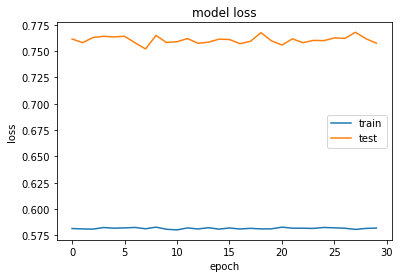

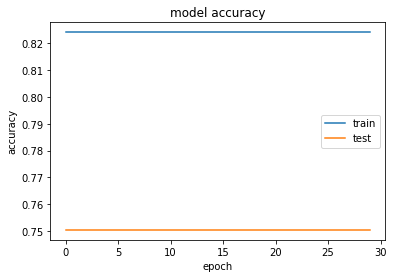

In [445]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()